# Tests

In [1]:
import os
import sys
import json
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
from termcolor import colored
import warnings
warnings.filterwarnings('ignore')

# change this property
NOMEROFF_NET_DIR = os.path.abspath('../')

# specify the path to Mask_RCNN if you placed it outside Nomeroff-net project
MASK_RCNN_DIR = os.path.join(NOMEROFF_NET_DIR, 'Mask_RCNN')

MASK_RCNN_LOG_DIR = "../logs/"
MASK_RCNN_MODEL_PATH = "../models/mask_rcnn_numberplate_0700.h5"
OPTIONS_MODEL_PATH =  "../models/numberplate_options_64x128-1_2019_2_15.h5"
OCR_NP_UKR_TEXT =  "../models/anpr_ocr_ua_1_2_11-cpu.h5"
OCR_NP_EU_TEXT =  "../models/anpr_ocr_eu_2-cpu.h5"

sys.path.append(NOMEROFF_NET_DIR)

In [2]:
from NomeroffNet import  filters, RectDetector, TextDetector, OptionsDetector, Detector, textPostprocessing

nnet = Detector(MASK_RCNN_DIR, MASK_RCNN_LOG_DIR)
nnet.loadModel(MASK_RCNN_MODEL_PATH)

rectDetector = RectDetector()

optionsDetector = OptionsDetector()
optionsDetector.load(OPTIONS_MODEL_PATH)

ukrTextDetector = TextDetector("ocr_ukr")
ukrTextDetector.load(OCR_NP_UKR_TEXT)

euTextDetector = TextDetector("ocr_eu")
euTextDetector.load(OCR_NP_EU_TEXT)

Using TensorFlow backend.


Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


In [3]:
import cv2
import numpy as np

def test(dirName, fname, y, verbose=0, max_img_w = 1280):
    img_path = os.path.join(dirName, fname)
    if verbose==1:
        print(colored(f"__________ \t\t {img_path} \t\t __________", "blue"))
    img = mpimg.imread(img_path)
    
    img_w = img.shape[1]
    img_h = img.shape[0]
    img_w_r = 1
    img_h_r = 1
    if img_w > max_img_w:
        resized_img = cv2.resize(img, (max_img_w, int(max_img_w/img_w*img_h)))
        img_w_r = img_w/max_img_w
        img_h_r = img_h/(max_img_w/img_w*img_h)
    else:
        resized_img = img
        
    NP = nnet.detect([resized_img])
    if verbose==1:
        print(colored("MASK_RCNN RESULTS:", "blue"))
        print(NP)
    cv_img_masks = filters.cv_img_mask(NP) 
    nGood = 0
    nBad = 0
    res = []
    for img_mask in cv_img_masks:
        #mpimg.imsave("masks/mask.png", img_mask)
        points = rectDetector.detect(img_mask, fixRectangleAngle=1, outboundWidthOffset=3/img_w_r)
        points = np.array(points)
        points[..., 1:2] = points[..., 1:2]*img_h_r
        points[..., 0:1] = points[..., 0:1]*img_w_r
        if verbose==1:
            print(colored("RECT DETECTOR RESULTS:", "blue"))
            print(points)
        zone = rectDetector.get_cv_zonesBGR(img, points)
        if verbose==1:
            plt.axis("off")
            plt.imshow(zone)
            plt.show()
        regionId, stateId = optionsDetector.predict(zone)
        print(regionId)
        regionName = optionsDetector.getRegionLabel(regionId)
        if verbose==1:
            print(colored("REGION NAME:", "blue"))
            print(regionName)
            
        if regionId in (1, 2):
            print("Ukr text detctor")
            text = ukrTextDetector.predict(zone)
        else:
            text = euTextDetector.predict(zone)
        if verbose==1:
            print(colored("SOURCE TEXT:", "blue"))
            print(text)
        text = textPostprocessing(text, regionName)
        if verbose==1:
            print(colored("POSTPROCESSED TEXT:", "blue"))
            print(text)
        res.append(text)
    for yText in y:
        if yText in res:
            print(colored(f"OK: TEXT:{yText} \t RESULTS:{res} \t\t in PATH:{img_path}", 'green'))
            nGood += 1
        else:
            print(colored(f"NOT OK: TEXT:{yText} \t RESULTS:{res} \t\t in PATH:{img_path} ", 'red'))
            nBad += 1
    return nGood, nBad

In [4]:
dirName = "images/"
testData = {
    "0.jpeg": ["AI5255EI"],
    "1.jpeg": ["HH7777CC"],
    "2.jpeg": ["AT1515CK"],
    "3.jpeg": ["BX0578CE"],
    "4.jpeg": ["AC4249CB"],
    "5.jpeg": ["BC3496HC"],
    "6.jpeg": ["BC3496HC"],
    "7.jpeg": ["AO1306CH"],
    "8.jpeg": ["AE1077CO"],
    "9.jpeg": ["AB3391AK"],
    "10.jpeg": ["BE7425CB"],
    "11.jpeg": ["BE7425CB"],
    "12.jpeg": ["AB0680EA"],
    "13.jpeg": ["AB0680EA"],
    "14.jpeg": ["BM1930BM"],
    "15.jpeg": ["AI1382HB"],
    "16.jpeg": ["AB7333BH"],
    "17.jpeg": ["AB7642CT"],
    "18.jpeg": ["AC4921CB"],
    "19.jpeg": ["BC9911BK"],
    "20.jpeg": ["BC7007AK"],
    "21.jpeg": ["AB5649CI"],
    "22.jpeg": ["AX2756EK"],
    "23.jpeg": ["AA7564MX"],
    "24.jpeg": ["AM5696CK"],
    "25.jpeg": ["AM5696CK"],
}

gGood = 0
gBad = 0
i = 0
for fileName in testData.keys():
    print(f"step {i}")
    nGood, nBad = test(dirName, fileName, testData[fileName], verbose=0)
    gGood += nGood
    gBad += nBad
    i += 1
total = gGood + gBad
print(f"TOTAL GOOD: {gGood/total}")
print(f"TOTAL BED: {gBad/total}")

step 0
1
Ukr text detctor
OK: TEXT:AI5255EI 	 RESULTS:['AI5255EI'] 		 in PATH:images/0.jpeg
step 1
1
Ukr text detctor
OK: TEXT:HH7777CC 	 RESULTS:['HH7777CC'] 		 in PATH:images/1.jpeg
step 2
1
Ukr text detctor
4
OK: TEXT:AT1515CK 	 RESULTS:['AT1515CK', 'RP69881'] 		 in PATH:images/2.jpeg
step 3
1
Ukr text detctor
OK: TEXT:BX0578CE 	 RESULTS:['BX0578CE'] 		 in PATH:images/3.jpeg
step 4
1
Ukr text detctor
OK: TEXT:AC4249CB 	 RESULTS:['AC4249CB'] 		 in PATH:images/4.jpeg
step 5
1
Ukr text detctor
OK: TEXT:BC3496HC 	 RESULTS:['BC3496HC'] 		 in PATH:images/5.jpeg
step 6
1
Ukr text detctor
OK: TEXT:BC3496HC 	 RESULTS:['BC3496HC'] 		 in PATH:images/6.jpeg
step 7
1
Ukr text detctor
OK: TEXT:AO1306CH 	 RESULTS:['AO1306CH'] 		 in PATH:images/7.jpeg
step 8
2
Ukr text detctor
OK: TEXT:AE1077CO 	 RESULTS:['AE1077CO'] 		 in PATH:images/8.jpeg
step 9
2
Ukr text detctor
OK: TEXT:AB3391AK 	 RESULTS:['AB3391AK'] 		 in PATH:images/9.jpeg
step 10
1
Ukr text detctor
OK: TEXT:BE7425CB 	 RESULTS:['BE7425CB']

__________ 		 images/20.jpeg 		 __________
MASK_RCNN RESULTS:
[{'rois': array([[688, 239, 727, 319]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9985398], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}]
RECT DETECTOR RESULTS:
[[ 763.37447746 2161.29774167]
 [1014.54010536 2201.

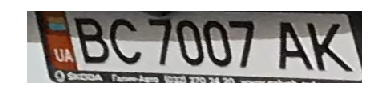

1
REGION NAME:
eu-ua-2015
Ukr text detctor
SOURCE TEXT:
BC7007AK
POSTPROCESSED TEXT:
BC7007AK
OK: TEXT:BC7007AK 	 RESULTS:['BC7007AK'] 		 in PATH:images/20.jpeg


In [5]:
nGood, nBad = test(dirName, "20.jpeg", ["BC7007AK"], verbose=1)